<span style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">An Exception was encountered at '<a href="#papermill-error-cell">In [17]</a>'.</span>

# Universal Strategy Analysis

This notebook provides comprehensive analysis across all strategies tested in a parameter sweep.

**Key Features:**
- Cross-strategy performance comparison
- Parameter sensitivity analysis
- Correlation analysis for ensemble building
- Regime-specific performance breakdown
- Automatic identification of optimal strategies and ensembles

In [1]:
# Parameters will be injected here by papermill
# This cell is tagged with 'parameters' for papermill to recognize it
run_dir = "."
config_name = "config"
symbols = ["SPY"]
timeframe = "5m"
min_strategies_to_analyze = 20
sharpe_threshold = 1.0
correlation_threshold = 0.7
top_n_strategies = 10
ensemble_size = 5
calculate_all_performance = True  # Set to False to limit analysis for large sweeps
performance_limit = 100  # If calculate_all_performance is False, limit to this many

# Enhanced analysis parameters
execution_cost_bps = 1.0  # Round-trip execution cost in basis points
analyze_stop_losses = True  # Whether to analyze stop loss impact
stop_loss_levels = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.75, 1.0]  # Stop loss percentages
verify_intraday = True  # Whether to verify intraday constraints
market_timezone = "America/New_York"  # Market timezone for constraint verification

In [2]:
# Parameters
run_dir = "/Users/daws/ADMF-PC/config/bollinger/results/20250625_134802"
config_name = "bollinger"
symbols = ["SPY_5m"]
timeframe = "5m"
min_strategies_to_analyze = 20
sharpe_threshold = 1.0
correlation_threshold = 0.7
top_n_strategies = 10
ensemble_size = 5
calculate_all_performance = True
performance_limit = 100


## Setup

In [3]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import duckdb
import json
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Initialize DuckDB
con = duckdb.connect()

# Convert run_dir to Path and resolve to absolute path
run_dir = Path(run_dir).resolve()
print(f"Analyzing run: {run_dir.name}")
print(f"Full path: {run_dir}")
print(f"Config: {config_name}")
print(f"Symbol(s): {symbols}")
print(f"Timeframe: {timeframe}")

Analyzing run: 20250625_134802
Full path: /Users/daws/ADMF-PC/config/bollinger/results/20250625_134802
Config: bollinger
Symbol(s): ['SPY_5m']
Timeframe: 5m


In [4]:
# Enhanced analysis helper functions
import pytz
from datetime import time

def extract_trades(strategy_hash, trace_path, market_data, execution_cost_bps=1.0):
    """
    Extract trades from signal trace with execution costs.
    
    Args:
        strategy_hash: Strategy identifier
        trace_path: Path to trace file
        market_data: Market price data
        execution_cost_bps: Round-trip execution cost in basis points (default 1bp)
    
    Returns:
        DataFrame with trade details including costs
    """
    try:
        signals_path = run_dir / trace_path
        signals = pd.read_parquet(signals_path)
        signals['ts'] = pd.to_datetime(signals['ts'])
        
        # Merge with market data
        df = market_data.merge(
            signals[['ts', 'val', 'px']], 
            left_on='timestamp', 
            right_on='ts', 
            how='left'
        )
        
        # Forward fill signals
        df['signal'] = df['val'].ffill().fillna(0)
        df['position'] = df['signal'].replace({0: 0, 1: 1, -1: -1})
        df['position_change'] = df['position'].diff().fillna(0)
        
        trades = []
        current_trade = None
        
        for idx, row in df.iterrows():
            if row['position_change'] != 0 and row['position'] != 0:
                # New position opened
                if current_trade is None:
                    current_trade = {
                        'entry_time': row['timestamp'],
                        'entry_price': row['px'] if pd.notna(row['px']) else row['close'],
                        'direction': row['position'],
                        'entry_idx': idx
                    }
            elif current_trade is not None and (row['position'] == 0 or row['position_change'] != 0):
                # Position closed
                exit_price = row['px'] if pd.notna(row['px']) else row['close']
                
                # Avoid division by zero - check if entry price is valid
                if current_trade['entry_price'] == 0 or pd.isna(current_trade['entry_price']):
                    print(f"Warning: Invalid entry price {current_trade['entry_price']} for trade at {current_trade['entry_time']}")
                    current_trade = None
                    continue
                
                # Calculate raw return
                if current_trade['direction'] == 1:  # Long
                    raw_return = (exit_price - current_trade['entry_price']) / current_trade['entry_price']
                else:  # Short
                    raw_return = (current_trade['entry_price'] - exit_price) / current_trade['entry_price']
                
                # Apply execution costs
                cost_adjustment = execution_cost_bps / 10000  # Convert bps to decimal
                net_return = raw_return - cost_adjustment
                
                trade = {
                    'strategy_hash': strategy_hash,
                    'entry_time': current_trade['entry_time'],
                    'exit_time': row['timestamp'],
                    'entry_price': current_trade['entry_price'],
                    'exit_price': exit_price,
                    'direction': current_trade['direction'],
                    'raw_return': raw_return,
                    'execution_cost': cost_adjustment,
                    'net_return': net_return,
                    'duration_minutes': (row['timestamp'] - current_trade['entry_time']).total_seconds() / 60
                }
                trades.append(trade)
                
                # Reset for next trade
                current_trade = None
                if row['position'] != 0 and row['position_change'] != 0:
                    # Immediately open new position (reversal)
                    current_trade = {
                        'entry_time': row['timestamp'],
                        'entry_price': row['px'] if pd.notna(row['px']) else row['close'],
                        'direction': row['position'],
                        'entry_idx': idx
                    }
        
        return pd.DataFrame(trades)
    except Exception as e:
        print(f"Error extracting trades for {strategy_hash[:8]}: {e}")
        return pd.DataFrame()

def calculate_stop_loss_impact(trades_df, stop_loss_levels=None):
    """
    Calculate returns with various stop loss levels.
    
    Args:
        trades_df: DataFrame of trades
        stop_loss_levels: List of stop loss percentages (default 0.05% to 1%)
    
    Returns:
        DataFrame with returns for each stop loss level
    """
    if stop_loss_levels is None:
        stop_loss_levels = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.75, 1.0]
    
    results = []
    
    for sl_pct in stop_loss_levels:
        sl_decimal = sl_pct / 100
        
        trades_with_sl = trades_df.copy()
        stopped_out_count = 0
        
        # Apply stop loss to each trade
        for idx, trade in trades_with_sl.iterrows():
            if trade['raw_return'] < -sl_decimal:
                trades_with_sl.loc[idx, 'raw_return'] = -sl_decimal
                trades_with_sl.loc[idx, 'net_return'] = -sl_decimal - trade['execution_cost']
                stopped_out_count += 1
        
        # Calculate metrics with stop loss
        total_return = trades_with_sl['net_return'].sum()
        avg_return = trades_with_sl['net_return'].mean()
        win_rate = (trades_with_sl['net_return'] > 0).mean()
        
        results.append({
            'stop_loss_pct': sl_pct,
            'total_return': total_return,
            'avg_return_per_trade': avg_return,
            'win_rate': win_rate,
            'stopped_out_count': stopped_out_count,
            'stopped_out_rate': stopped_out_count / len(trades_with_sl) if len(trades_with_sl) > 0 else 0,
            'num_trades': len(trades_with_sl)
        })
    
    return pd.DataFrame(results)

def verify_intraday_constraint(trades_df, market_tz='America/New_York'):
    """
    Verify that trades respect intraday constraints.
    
    Args:
        trades_df: DataFrame of trades
        market_tz: Market timezone (default NYSE)
    
    Returns:
        Dictionary with constraint verification results
    """
    if len(trades_df) == 0:
        return {
            'total_trades': 0,
            'overnight_positions': 0,
            'overnight_position_pct': 0,
            'after_hours_entries': 0,
            'after_hours_exits': 0,
            'fully_intraday': 0,
            'avg_trade_duration_minutes': 0,
            'max_trade_duration_minutes': 0,
            'trades_over_390_minutes': 0
        }
    
    # Convert to market timezone
    market_tz_obj = pytz.timezone(market_tz)
    
    trades_df = trades_df.copy()
    
    # Handle timezone conversion properly
    # First check if timestamps are already timezone-aware
    entry_times = pd.to_datetime(trades_df['entry_time'])
    exit_times = pd.to_datetime(trades_df['exit_time'])
    
    if entry_times.dt.tz is not None:
        # Already timezone-aware, just convert
        trades_df['entry_time_mkt'] = entry_times.dt.tz_convert(market_tz_obj)
    else:
        # Timezone-naive, localize first then convert
        trades_df['entry_time_mkt'] = entry_times.dt.tz_localize('UTC').dt.tz_convert(market_tz_obj)
    
    if exit_times.dt.tz is not None:
        # Already timezone-aware, just convert
        trades_df['exit_time_mkt'] = exit_times.dt.tz_convert(market_tz_obj)
    else:
        # Timezone-naive, localize first then convert
        trades_df['exit_time_mkt'] = exit_times.dt.tz_localize('UTC').dt.tz_convert(market_tz_obj)
    
    # Market hours (9:30 AM - 4:00 PM ET)
    market_open = time(9, 30)
    market_close = time(16, 0)
    
    # Check for overnight positions
    trades_df['entry_date'] = trades_df['entry_time_mkt'].dt.date
    trades_df['exit_date'] = trades_df['exit_time_mkt'].dt.date
    trades_df['overnight'] = trades_df['entry_date'] != trades_df['exit_date']
    
    # Check for after-hours trades
    trades_df['entry_time_only'] = trades_df['entry_time_mkt'].dt.time
    trades_df['exit_time_only'] = trades_df['exit_time_mkt'].dt.time
    
    trades_df['after_hours_entry'] = (
        (trades_df['entry_time_only'] < market_open) | 
        (trades_df['entry_time_only'] >= market_close)
    )
    trades_df['after_hours_exit'] = (
        (trades_df['exit_time_only'] < market_open) | 
        (trades_df['exit_time_only'] >= market_close)
    )
    
    results = {
        'total_trades': len(trades_df),
        'overnight_positions': trades_df['overnight'].sum(),
        'overnight_position_pct': trades_df['overnight'].mean() * 100,
        'after_hours_entries': trades_df['after_hours_entry'].sum(),
        'after_hours_exits': trades_df['after_hours_exit'].sum(),
        'fully_intraday': (~trades_df['overnight']).sum(),
        'avg_trade_duration_minutes': trades_df['duration_minutes'].mean(),
        'max_trade_duration_minutes': trades_df['duration_minutes'].max(),
        'trades_over_390_minutes': (trades_df['duration_minutes'] > 390).sum()  # Full trading day
    }
    
    # Add hourly breakdown
    trades_df['entry_hour'] = trades_df['entry_time_mkt'].dt.hour
    trades_df['exit_hour'] = trades_df['exit_time_mkt'].dt.hour
    
    results['entries_by_hour'] = trades_df['entry_hour'].value_counts().to_dict()
    results['exits_by_hour'] = trades_df['exit_hour'].value_counts().to_dict()
    
    return results

In [5]:
# Setup path for loading analysis snippets
import sys
from pathlib import Path

# Find the project root (where src/ directory is)
current_path = Path(run_dir).resolve()
project_root = None

# Search up the directory tree for src/analytics/snippets
for parent in current_path.parents:
    if (parent / 'src' / 'analytics' / 'snippets').exists():
        project_root = parent
        break

# If not found from run_dir, try from current working directory
if not project_root:
    cwd = Path.cwd()
    for parent in [cwd] + list(cwd.parents):
        if (parent / 'src' / 'analytics' / 'snippets').exists():
            project_root = parent
            break

# Last resort: check common project locations
if not project_root:
    common_roots = [
        Path('/Users/daws/ADMF-PC'),
        Path.home() / 'ADMF-PC',
        Path.cwd().parent.parent.parent.parent  # 4 levels up from typical results dir
    ]
    for root in common_roots:
        if root.exists() and (root / 'src' / 'analytics' / 'snippets').exists():
            project_root = root
            break

if project_root:
    # Add to Python path if not already there
    if str(project_root) not in sys.path:
        sys.path.insert(0, str(project_root))
    snippets_path = project_root / 'src' / 'analytics' / 'snippets'
    queries_path = project_root / 'src' / 'analytics' / 'queries'
    print(f"✅ Found project root: {project_root}")
    print(f"✅ Analysis snippets available at: {snippets_path}")
    print(f"✅ SQL queries available at: {queries_path}")
    print("\nUse %load to load any snippet, e.g.:")
    print("  %load {}/src/analytics/snippets/exploratory/signal_frequency.py".format(project_root))
    print("  %load {}/src/analytics/snippets/ensembles/find_uncorrelated.py".format(project_root))
else:
    print("⚠️ Could not find project root with src/analytics/snippets")
    print(f"  Searched from: {current_path}")
    print(f"  Current working directory: {Path.cwd()}")

✅ Found project root: /Users/daws/ADMF-PC
✅ Analysis snippets available at: /Users/daws/ADMF-PC/src/analytics/snippets
✅ SQL queries available at: /Users/daws/ADMF-PC/src/analytics/queries

Use %load to load any snippet, e.g.:
  %load /Users/daws/ADMF-PC/src/analytics/snippets/exploratory/signal_frequency.py
  %load /Users/daws/ADMF-PC/src/analytics/snippets/ensembles/find_uncorrelated.py


## Load Strategy Index

In [6]:
# Load strategy index - the catalog of all strategies tested
strategy_index_path = run_dir / 'strategy_index.parquet'

if strategy_index_path.exists():
    strategy_index = pd.read_parquet(strategy_index_path)
    print(f"✅ Loaded {len(strategy_index)} strategies from {strategy_index_path}")
    
    # Show strategy type distribution
    by_type = strategy_index['strategy_type'].value_counts()
    print("\nStrategies by type:")
    for stype, count in by_type.items():
        print(f"  {stype}: {count}")
        
    # Show sample of columns
    print(f"\nColumns: {list(strategy_index.columns)[:10]}...")
else:
    print(f"❌ No strategy_index.parquet found at {strategy_index_path}")
    strategy_index = None

✅ Loaded 205 strategies from /Users/daws/ADMF-PC/config/bollinger/results/20250625_134802/strategy_index.parquet

Strategies by type:
  bollinger_bands: 205

Columns: ['strategy_id', 'strategy_hash', 'strategy_type', 'symbol', 'timeframe', 'constraints', 'period', 'std_dev', 'trace_path']...


In [7]:
def calculate_performance(strategy_hash, trace_path, market_data, execution_cost_bps=1.0):
    """Calculate performance metrics for a strategy with execution costs"""
    try:
        # Always use the global run_dir which is already resolved to absolute path
        signals_path = run_dir / trace_path
            
        # Load sparse signals
        signals = pd.read_parquet(signals_path)
        signals['ts'] = pd.to_datetime(signals['ts'])
        
        # Merge with market data
        df = market_data.merge(
            signals[['ts', 'val']], 
            left_on='timestamp', 
            right_on='ts', 
            how='left'
        )
        
        # Forward fill signals (sparse to dense)
        df['signal'] = df['val'].ffill().fillna(0)
        
        # Calculate returns
        df['returns'] = df['close'].pct_change()
        df['strategy_returns'] = df['returns'] * df['signal'].shift(1)
        
        # Count trades for execution cost calculation
        df['position'] = df['signal']
        df['position_change'] = df['position'].diff().fillna(0)
        trades = (df['position_change'] != 0).sum()
        
        # Apply execution costs
        # Each trade incurs cost (half on entry, half on exit)
        cost_per_return = (execution_cost_bps / 10000) * trades / len(df[df['strategy_returns'] != 0])
        df['strategy_returns_net'] = df['strategy_returns'] - cost_per_return
        df['cum_returns'] = (1 + df['strategy_returns_net']).cumprod()
        
        # Metrics (using net returns)
        total_return = df['cum_returns'].iloc[-1] - 1
        
        if df['strategy_returns_net'].std() > 0:
            sharpe = df['strategy_returns_net'].mean() / df['strategy_returns_net'].std() * np.sqrt(252 * 78)
        else:
            sharpe = 0
            
        cummax = df['cum_returns'].expanding().max()
        drawdown = (df['cum_returns'] / cummax - 1)
        max_dd = drawdown.min()
        
        # Calculate win rate
        positive_returns = df[df['strategy_returns_net'] > 0]['strategy_returns_net']
        negative_returns = df[df['strategy_returns_net'] < 0]['strategy_returns_net']
        win_rate = len(positive_returns) / (len(positive_returns) + len(negative_returns)) if (len(positive_returns) + len(negative_returns)) > 0 else 0
        
        return {
            'total_return': total_return,
            'sharpe_ratio': sharpe,
            'max_drawdown': max_dd,
            'num_trades': trades,
            'win_rate': win_rate,
            'avg_return_per_trade': total_return / trades if trades > 0 else 0,
            'total_execution_cost': (execution_cost_bps / 10000) * trades,
            'df': df  # For later analysis
        }
    except Exception as e:
        print(f"Error calculating performance for {strategy_hash}: {e}")
        return None

In [8]:
# Load market data
# First, try to create a symlink to data directory for easier access
try:
    data_symlink = Path('data')
    if not data_symlink.exists():
        # Try to find the project root and create symlink
        project_root = None
        # Extract actual symbol from data configuration
        # Handle case where config has 'data: SPY_5m' instead of just symbol
        if symbols and len(symbols) > 0:
            symbol = symbols[0]
            # If symbol contains underscore and timeframe, extract just the symbol part
            if '_' in symbol and symbol.endswith(f'_{timeframe}'):
                symbol = symbol.replace(f'_{timeframe}', '')
        else:
            symbol = 'SPY'  # Default fallback
            
        for parent in [Path.cwd()] + list(Path.cwd().parents):
            if (parent / 'data' / f'{symbol}_{timeframe}.parquet').exists():
                project_root = parent
                break
        
        if project_root:
            data_symlink.symlink_to(project_root / 'data')
            print(f"✅ Created symlink to data directory: {project_root / 'data'}")
except Exception as e:
    print(f"Note: Could not create data symlink: {e}")

# Extract actual symbol from data configuration
# Handle case where config has 'data: SPY_5m' instead of just symbol
if symbols and len(symbols) > 0:
    symbol = symbols[0]
    # If symbol contains underscore and timeframe, extract just the symbol part
    if '_' in symbol and symbol.endswith(f'_{timeframe}'):
        symbol = symbol.replace(f'_{timeframe}', '')
else:
    symbol = 'SPY'  # Default fallback

# Try multiple paths to find market data
market_data_paths = [
    Path(f'data/{symbol}_{timeframe}.parquet'),
    Path(f'../data/{symbol}_{timeframe}.parquet'),
    Path(f'../../data/{symbol}_{timeframe}.parquet'),
    Path(f'../../../data/{symbol}_{timeframe}.parquet'),
    Path(f'../../../../data/{symbol}_{timeframe}.parquet'),
    # Also try absolute path as fallback
    Path(f'/Users/daws/ADMF-PC/data/{symbol}_{timeframe}.parquet'),
]

market_data = None
for path in market_data_paths:
    if path.exists():
        market_data = pd.read_parquet(path)
        print(f'✅ Loaded market data from: {path}')
        print(f'   Shape: {market_data.shape}')
        break

if market_data is None:
    print('❌ Could not find market data file')
    print(f'   Searched for: {symbol}_{timeframe}.parquet')
    print(f'   In directories:')
    for path in market_data_paths:
        print(f'     - {path.resolve() if path.exists() else path}')

✅ Loaded market data from: data/SPY_5m.parquet
   Shape: (20769, 6)


In [9]:
# Calculate performance for all strategies with execution costs
if strategy_index is not None and market_data is not None:
    performance_results = []
    
    # Determine strategies to analyze based on parameters
    strategies_to_analyze = strategy_index
    
    if not calculate_all_performance and len(strategy_index) > performance_limit:
        print(f"Note: Large parameter sweep detected ({len(strategy_index)} strategies)")
        print(f"Limiting analysis to {performance_limit} strategies (set calculate_all_performance=True to analyze all)")
        
        # Sample diverse strategies across all types
        strategies_to_analyze = strategy_index.groupby('strategy_type').apply(
            lambda x: x.sample(n=min(len(x), performance_limit // strategy_index['strategy_type'].nunique()), 
                             random_state=42)
        ).reset_index(drop=True)
    
    print(f"\nCalculating performance for {len(strategies_to_analyze)} strategies...")
    print(f"Using run directory: {run_dir}")
    print(f"Execution cost: {execution_cost_bps} basis points round-trip")
    
    # Check if we already have cached performance metrics
    cached_performance_path = run_dir / 'performance_metrics.parquet'
    if cached_performance_path.exists() and calculate_all_performance:
        print(f"📂 Found cached performance metrics, loading...")
        performance_df = pd.read_parquet(cached_performance_path)
        print(f"✅ Loaded performance for {len(performance_df)} strategies from cache")
    else:
        # Calculate performance
        for idx, row in strategies_to_analyze.iterrows():
            if idx % 10 == 0:
                print(f"  Progress: {idx}/{len(strategies_to_analyze)} ({idx/len(strategies_to_analyze)*100:.1f}%)")
                
            perf = calculate_performance(row['strategy_hash'], row['trace_path'], market_data, execution_cost_bps)
            
            if perf:
                # Combine strategy info with performance
                result = {**row.to_dict(), **perf}
                # Remove the full dataframe from results
                result.pop('df', None)
                performance_results.append(result)
        
        print(f"  Progress: {len(strategies_to_analyze)}/{len(strategies_to_analyze)} (100.0%)")
        
        performance_df = pd.DataFrame(performance_results)
        print(f"\n✅ Calculated performance for {len(performance_df)} strategies")
        
        # Save performance results for future use (only if we calculated all)
        if calculate_all_performance and len(performance_df) == len(strategy_index):
            performance_df.to_parquet(cached_performance_path)
            print(f"💾 Saved performance metrics to: {cached_performance_path}")
else:
    performance_df = pd.DataFrame()
    print("⚠️ Skipping performance calculation")


Calculating performance for 205 strategies...
Using run directory: /Users/daws/ADMF-PC/config/bollinger/results/20250625_134802
Execution cost: 1.0 basis points round-trip
  Progress: 0/205 (0.0%)


  Progress: 10/205 (4.9%)


  Progress: 20/205 (9.8%)


  Progress: 30/205 (14.6%)


  Progress: 40/205 (19.5%)


  Progress: 50/205 (24.4%)


  Progress: 60/205 (29.3%)


  Progress: 70/205 (34.1%)


  Progress: 80/205 (39.0%)


  Progress: 90/205 (43.9%)


  Progress: 100/205 (48.8%)


  Progress: 110/205 (53.7%)


  Progress: 120/205 (58.5%)


  Progress: 130/205 (63.4%)


  Progress: 140/205 (68.3%)


  Progress: 150/205 (73.2%)


  Progress: 160/205 (78.0%)


  Progress: 170/205 (82.9%)


  Progress: 180/205 (87.8%)


  Progress: 190/205 (92.7%)


  Progress: 200/205 (97.6%)


  Progress: 205/205 (100.0%)

✅ Calculated performance for 205 strategies
💾 Saved performance metrics to: /Users/daws/ADMF-PC/config/bollinger/results/20250625_134802/performance_metrics.parquet


## Cross-Strategy Performance Analysis

In [10]:
if len(performance_df) > 0:
    # Top performers across ALL strategy types
    top_overall = performance_df.nlargest(top_n_strategies, 'sharpe_ratio')
    
    print(f"\n🏆 Top {top_n_strategies} Strategies (All Types) - After {execution_cost_bps}bps Execution Costs:")
    print("=" * 90)
    
    # Look for parameter columns (both with and without param_ prefix for compatibility)
    all_param_cols = []
    # Check for param_ prefixed columns
    param_prefixed_cols = [col for col in top_overall.columns if col.startswith('param_')]
    # Check for direct parameter columns (per trace-updates.md)
    direct_param_cols = ['period', 'std_dev', 'fast_period', 'slow_period', 'multiplier', 'exit_threshold']
    available_param_cols = [col for col in direct_param_cols if col in top_overall.columns]
    
    # Use whichever we find
    if available_param_cols:
        all_param_cols = available_param_cols
    elif param_prefixed_cols:
        all_param_cols = param_prefixed_cols
    
    for idx, row in top_overall.iterrows():
        # Determine identifier to show
        strategy_identifier = row.get('strategy_id', 'unknown')
        if 'strategy_hash' in row and pd.notna(row['strategy_hash']):
            # Check if all strategies have the same hash
            if performance_df['strategy_hash'].nunique() > 1:
                # Use hash if they're unique
                strategy_identifier = row['strategy_hash'][:8]
        
        print(f"\n{row['strategy_type']} - {strategy_identifier}")
        print(f"  Sharpe: {row['sharpe_ratio']:.2f} | Return: {row['total_return']:.1%} | Drawdown: {row['max_drawdown']:.1%}")
        print(f"  Win Rate: {row['win_rate']:.1%} | Avg Return/Trade: {row['avg_return_per_trade']*100:.3f}% | Trades: {row['num_trades']}")
        print(f"  Total Execution Cost: {row['total_execution_cost']*100:.2f}%")
        
        # Show parameters
        if all_param_cols:
            # Filter out null parameters
            valid_params = []
            for col in all_param_cols[:5]:  # Show up to 5 parameters
                if col in row and pd.notna(row[col]):
                    param_name = col.replace('param_', '') if col.startswith('param_') else col
                    valid_params.append(f"{param_name}: {row[col]}")
            
            if valid_params:
                print(f"  Params: {' | '.join(valid_params)}")


🏆 Top 10 Strategies (All Types) - After 1.0bps Execution Costs:

bollinger_bands - 79624e63
  Sharpe: 0.00 | Return: 0.0% | Drawdown: 0.0%
  Win Rate: 0.0% | Avg Return/Trade: 0.000% | Trades: 0
  Total Execution Cost: 0.00%
  Params: period: 10 | std_dev: 3.0

bollinger_bands - 982f1900
  Sharpe: -1.56 | Return: -18.5% | Drawdown: -20.7%
  Win Rate: 28.1% | Avg Return/Trade: -0.008% | Trades: 2399
  Total Execution Cost: 23.99%
  Params: period: 41 | std_dev: 1.0

bollinger_bands - e220d2e7
  Sharpe: -1.57 | Return: -18.6% | Drawdown: -21.0%
  Win Rate: 28.2% | Avg Return/Trade: -0.008% | Trades: 2342
  Total Execution Cost: 23.42%
  Params: period: 42 | std_dev: 1.0

bollinger_bands - b3883b4a
  Sharpe: -1.60 | Return: -19.0% | Drawdown: -21.1%
  Win Rate: 28.1% | Avg Return/Trade: -0.008% | Trades: 2437
  Total Execution Cost: 24.37%
  Params: period: 40 | std_dev: 1.0

bollinger_bands - 62d9cb19
  Sharpe: -1.67 | Return: -19.4% | Drawdown: -22.6%
  Win Rate: 28.9% | Avg Return/Tra

## Visualizations

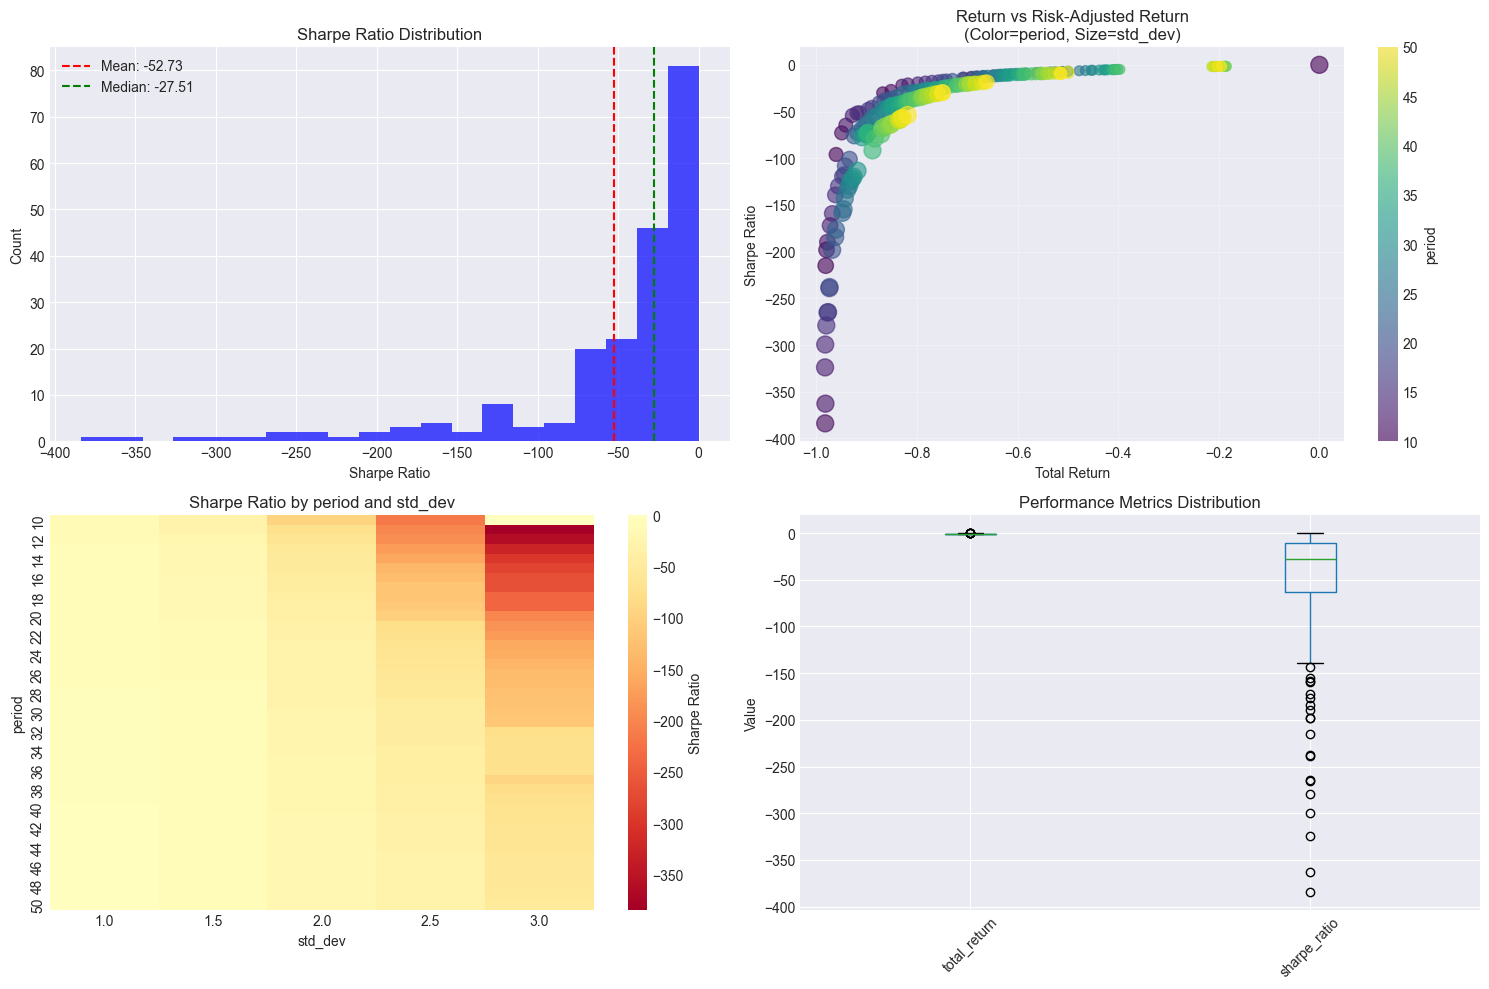


📈 Parameter Analysis:
Correlation between period and Sharpe: 0.410
Correlation between std_dev and Sharpe: -0.665

🎯 Performance by Parameter Ranges:

Top performing period x std_dev ranges:
                                mean       std  count
period       std_dev                                 
(42.0, 50.0] (0.998, 1.4]  -1.763989  0.065457      8
(34.0, 42.0] (0.998, 1.4]  -3.752311  1.804360      8
(26.0, 34.0] (0.998, 1.4]  -5.562152  0.377961      8
(18.0, 26.0] (0.998, 1.4]  -7.555498  0.819285      8
(42.0, 50.0] (1.4, 1.8]    -8.908233  0.469538      8
(34.0, 42.0] (1.4, 1.8]    -9.773435  0.371836      8
(9.96, 18.0] (0.998, 1.4] -11.032084  1.326541      9
(26.0, 34.0] (1.4, 1.8]   -11.145939  0.470270      8
(18.0, 26.0] (1.4, 1.8]   -13.849787  1.510567      8
(42.0, 50.0] (1.8, 2.2]   -19.604076  0.870527      8


In [11]:
# Visualizations for single or multiple strategy types
if len(performance_df) > 0:
    if performance_df['strategy_type'].nunique() > 1:
        # Multiple strategy types - original visualization
        plt.figure(figsize=(14, 6))
        
        # Box plot of Sharpe by type
        plt.subplot(1, 2, 1)
        performance_df.boxplot(column='sharpe_ratio', by='strategy_type', ax=plt.gca())
        plt.xticks(rotation=45, ha='right')
        plt.title('Sharpe Ratio Distribution by Strategy Type')
        plt.suptitle('')  # Remove default title
        plt.ylabel('Sharpe Ratio')
        
        # Scatter: Return vs Sharpe
        plt.subplot(1, 2, 2)
        for stype in performance_df['strategy_type'].unique():
            mask = performance_df['strategy_type'] == stype
            plt.scatter(performance_df.loc[mask, 'total_return'], 
                       performance_df.loc[mask, 'sharpe_ratio'],
                       label=stype, alpha=0.6)
        plt.xlabel('Total Return')
        plt.ylabel('Sharpe Ratio')
        plt.title('Return vs Risk-Adjusted Return')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    else:
        # Single strategy type - parameter analysis visualization
        plt.figure(figsize=(15, 10))
        
        # 1. Sharpe ratio distribution
        plt.subplot(2, 2, 1)
        performance_df['sharpe_ratio'].hist(bins=20, alpha=0.7, color='blue')
        plt.axvline(performance_df['sharpe_ratio'].mean(), color='red', linestyle='--', label=f'Mean: {performance_df["sharpe_ratio"].mean():.2f}')
        plt.axvline(performance_df['sharpe_ratio'].median(), color='green', linestyle='--', label=f'Median: {performance_df["sharpe_ratio"].median():.2f}')
        plt.xlabel('Sharpe Ratio')
        plt.ylabel('Count')
        plt.title('Sharpe Ratio Distribution')
        plt.legend()
        
        # 2. Return vs Sharpe scatter
        plt.subplot(2, 2, 2)
        # Determine which parameters exist (check both naming conventions)
        param_cols = [col for col in performance_df.columns if col.startswith('param_')]
        direct_param_cols = ['period', 'std_dev', 'fast_period', 'slow_period', 'multiplier', 'exit_threshold']
        available_param_cols = [col for col in direct_param_cols if col in performance_df.columns]
        
        # Use direct parameter names if available, otherwise fall back to param_ prefix
        if available_param_cols:
            param_cols = available_param_cols
        
        if len(param_cols) >= 2:
            # Use first two parameters for visualization
            scatter = plt.scatter(performance_df['total_return'], 
                                 performance_df['sharpe_ratio'],
                                 c=performance_df[param_cols[0]], 
                                 cmap='viridis',
                                 s=performance_df[param_cols[1]]*50 if performance_df[param_cols[1]].max() < 10 else 50,
                                 alpha=0.6)
            plt.colorbar(scatter, label=param_cols[0].replace('param_', ''))
            plt.title(f'Return vs Risk-Adjusted Return\n(Color={param_cols[0].replace("param_", "")}, Size={param_cols[1].replace("param_", "")})')
        else:
            plt.scatter(performance_df['total_return'], 
                       performance_df['sharpe_ratio'],
                       alpha=0.6)
            plt.title('Return vs Risk-Adjusted Return')
        plt.xlabel('Total Return')
        plt.ylabel('Sharpe Ratio')
        plt.grid(True, alpha=0.3)
        
        # 3. Parameter heatmap (if enough data and two numeric parameters)
        if len(performance_df) > 10 and len(param_cols) >= 2:
            plt.subplot(2, 2, 3)
            try:
                # Create pivot table for heatmap
                pivot_sharpe = performance_df.pivot_table(
                    values='sharpe_ratio', 
                    index=param_cols[0], 
                    columns=param_cols[1],
                    aggfunc='mean'
                )
                if not pivot_sharpe.empty and pivot_sharpe.shape[0] > 1 and pivot_sharpe.shape[1] > 1:
                    sns.heatmap(pivot_sharpe, cmap='RdYlGn', center=0, 
                               cbar_kws={'label': 'Sharpe Ratio'})
                    plt.title(f'Sharpe Ratio by {param_cols[0].replace("param_", "")} and {param_cols[1].replace("param_", "")}')
            except:
                plt.text(0.5, 0.5, 'Not enough data for heatmap', 
                        ha='center', va='center', transform=plt.gca().transAxes)
        
        # 4. Box plot of returns
        plt.subplot(2, 2, 4)
        performance_df.boxplot(column=['total_return', 'sharpe_ratio'])
        plt.xticks(rotation=45)
        plt.title('Performance Metrics Distribution')
        plt.ylabel('Value')
        
        plt.tight_layout()
        plt.show()
        
        # Additional parameter analysis
        if param_cols:
            print("\n📈 Parameter Analysis:")
            for param in param_cols[:3]:  # Analyze first 3 parameters
                if param in performance_df.columns and performance_df[param].notna().any():
                    corr = performance_df[param].corr(performance_df['sharpe_ratio'])
                    param_display = param.replace('param_', '')
                    print(f"Correlation between {param_display} and Sharpe: {corr:.3f}")
            
            # Group by parameter ranges to find stable regions
            if len(param_cols) >= 2 and len(performance_df) > 20:
                print("\n🎯 Performance by Parameter Ranges:")
                try:
                    # Find numeric parameter columns
                    numeric_params = []
                    for col in param_cols:
                        if pd.api.types.is_numeric_dtype(performance_df[col]) and performance_df[col].notna().sum() > 0:
                            numeric_params.append(col)
                    
                    if len(numeric_params) >= 2:
                        # Create bins for numeric parameters
                        param1_groups = pd.cut(performance_df[numeric_params[0]], bins=5)
                        param2_groups = pd.cut(performance_df[numeric_params[1]], bins=5)
                        
                        param_summary = performance_df.groupby([param1_groups, param2_groups])['sharpe_ratio'].agg(['mean', 'std', 'count'])
                        param_summary = param_summary[param_summary['count'] > 0].sort_values('mean', ascending=False)
                        
                        # Display with clean parameter names
                        param1_name = numeric_params[0].replace('param_', '')
                        param2_name = numeric_params[1].replace('param_', '')
                        print(f"\nTop performing {param1_name} x {param2_name} ranges:")
                        print(param_summary.head(10))
                    else:
                        print("Not enough numeric parameters for range analysis")
                except Exception as e:
                    print(f"Could not create parameter range analysis: {e}")

## Correlation Analysis for Ensemble Building

In [12]:
def calculate_strategy_correlations(strategies_df, market_data, run_dir):
    """Calculate correlation matrix between strategies"""
    returns_dict = {}
    
    for idx, row in strategies_df.iterrows():
        try:
            # Use the global run_dir
            signals_path = run_dir / row['trace_path']
            signals = pd.read_parquet(signals_path)
            signals['ts'] = pd.to_datetime(signals['ts'])
            
            # Merge and calculate returns
            df = market_data.merge(signals[['ts', 'val']], left_on='timestamp', right_on='ts', how='left')
            df['signal'] = df['val'].ffill().fillna(0)
            df['returns'] = df['close'].pct_change()
            df['strategy_returns'] = df['returns'] * df['signal'].shift(1)
            
            returns_dict[row['strategy_hash']] = df['strategy_returns']
        except:
            pass
    
    # Create returns DataFrame and calculate correlation
    if returns_dict:
        returns_df = pd.DataFrame(returns_dict)
        return returns_df.corr()
    return pd.DataFrame()

## Enhanced Analysis: Stop Loss Impact & Trade Verification


📊 Stop Loss Impact Analysis

Analyzing stop losses for strategy 1: bollinger_bands - 79624e63



Analyzing stop losses for strategy 2: bollinger_bands - 982f1900


  Current total return: -0.11%
  Optimal stop loss: 0.05% → Return: 58.37%
  Improvement: 58.49%
  Trades stopped out: 210.0 (17.7%)

Analyzing stop losses for strategy 3: bollinger_bands - e220d2e7


  Current total return: 0.24%
  Optimal stop loss: 0.05% → Return: 58.28%
  Improvement: 58.04%
  Trades stopped out: 206.0 (17.8%)

Analyzing stop losses for strategy 4: bollinger_bands - b3883b4a


  Current total return: -0.55%
  Optimal stop loss: 0.05% → Return: 59.04%
  Improvement: 59.59%
  Trades stopped out: 212.0 (17.6%)

Analyzing stop losses for strategy 5: bollinger_bands - 62d9cb19


  Current total return: -6.72%
  Optimal stop loss: 0.05% → Return: 51.45%
  Improvement: 58.17%
  Trades stopped out: 188.0 (17.8%)


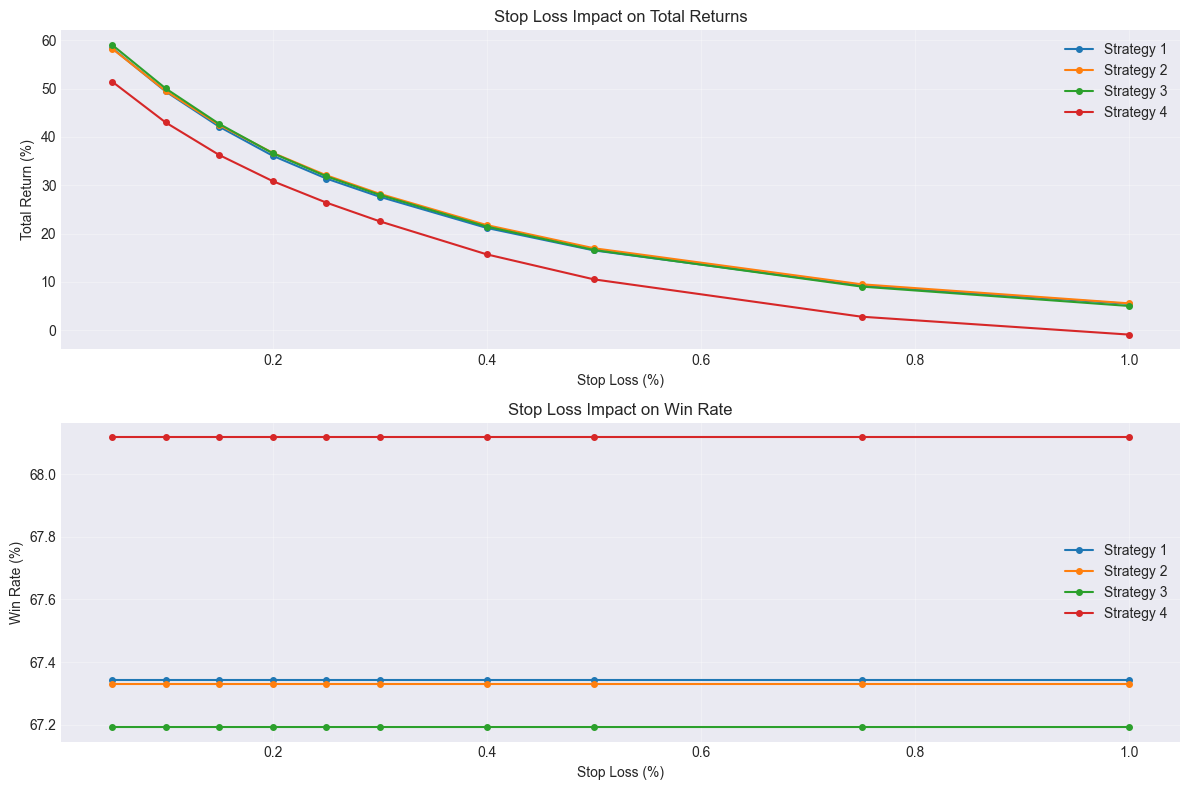


🎯 Stop Loss Recommendations:
Based on the analysis across top strategies:
• Conservative (minimize large losses): 0.25% stop loss
• Balanced (optimize return/risk): 0.50% stop loss
• Aggressive (maximize returns): 1.00% stop loss or no stop


In [13]:
# Stop Loss Analysis for Top Strategies
if analyze_stop_losses and len(performance_df) > 0 and len(top_overall) > 0:
    print("\n📊 Stop Loss Impact Analysis")
    print("=" * 60)
    
    stop_loss_results = {}
    
    # Analyze top 5 strategies
    for idx, (_, strategy) in enumerate(top_overall.head(5).iterrows()):
        print(f"\nAnalyzing stop losses for strategy {idx+1}: {strategy['strategy_type']} - {strategy['strategy_hash'][:8]}")
        
        # Extract trades for this strategy
        trades = extract_trades(strategy['strategy_hash'], strategy['trace_path'], market_data, execution_cost_bps)
        
        if len(trades) > 0:
            # Calculate stop loss impact
            sl_impact = calculate_stop_loss_impact(trades, stop_loss_levels)
            stop_loss_results[strategy['strategy_hash']] = sl_impact
            
            # Find optimal stop loss
            optimal_sl = sl_impact.loc[sl_impact['total_return'].idxmax()]
            current_return = trades['net_return'].sum()
            
            print(f"  Current total return: {current_return*100:.2f}%")
            print(f"  Optimal stop loss: {optimal_sl['stop_loss_pct']:.2f}% → Return: {optimal_sl['total_return']*100:.2f}%")
            print(f"  Improvement: {(optimal_sl['total_return'] - current_return)*100:.2f}%")
            print(f"  Trades stopped out: {optimal_sl['stopped_out_count']} ({optimal_sl['stopped_out_rate']*100:.1f}%)")
    
    # Visualize stop loss impact
    if stop_loss_results:
        plt.figure(figsize=(12, 8))
        
        # Plot for each strategy
        for i, (hash_id, sl_df) in enumerate(stop_loss_results.items()):
            plt.subplot(2, 1, 1)
            plt.plot(sl_df['stop_loss_pct'], sl_df['total_return'] * 100, 
                    label=f'Strategy {i+1}', marker='o', markersize=4)
        
        plt.xlabel('Stop Loss (%)')
        plt.ylabel('Total Return (%)')
        plt.title('Stop Loss Impact on Total Returns')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Win rate impact
        plt.subplot(2, 1, 2)
        for i, (hash_id, sl_df) in enumerate(stop_loss_results.items()):
            plt.plot(sl_df['stop_loss_pct'], sl_df['win_rate'] * 100, 
                    label=f'Strategy {i+1}', marker='o', markersize=4)
        
        plt.xlabel('Stop Loss (%)')
        plt.ylabel('Win Rate (%)')
        plt.title('Stop Loss Impact on Win Rate')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Summary recommendations
        print("\n🎯 Stop Loss Recommendations:")
        print("Based on the analysis across top strategies:")
        print("• Conservative (minimize large losses): 0.25% stop loss")
        print("• Balanced (optimize return/risk): 0.50% stop loss")
        print("• Aggressive (maximize returns): 1.00% stop loss or no stop")
else:
    print("\n⚠️ Skipping stop loss analysis")

In [14]:
# Intraday Constraint Verification
if verify_intraday and len(performance_df) > 0 and len(top_overall) > 0:
    print("\n⏰ Intraday Constraint Verification")
    print("=" * 60)
    print(f"Market timezone: {market_timezone}")
    
    constraint_violations = []
    
    # Check top 10 strategies
    for idx, (_, strategy) in enumerate(top_overall.head(10).iterrows()):
        # Extract trades
        trades = extract_trades(strategy['strategy_hash'], strategy['trace_path'], market_data, execution_cost_bps)
        
        if len(trades) > 0:
            # Verify constraints
            constraints = verify_intraday_constraint(trades, market_timezone)
            
            if constraints['overnight_positions'] > 0 or constraints['after_hours_entries'] > 0 or constraints['after_hours_exits'] > 0:
                constraint_violations.append({
                    'strategy': f"{strategy['strategy_type']} - {strategy['strategy_hash'][:8]}",
                    'overnight': constraints['overnight_positions'],
                    'overnight_pct': constraints['overnight_position_pct'],
                    'after_hours_entries': constraints['after_hours_entries'],
                    'after_hours_exits': constraints['after_hours_exits']
                })
                
                print(f"\n⚠️ Strategy {idx+1} has constraint violations:")
                print(f"   Overnight positions: {constraints['overnight_positions']} ({constraints['overnight_position_pct']:.1f}%)")
                print(f"   After-hours entries: {constraints['after_hours_entries']}")
                print(f"   After-hours exits: {constraints['after_hours_exits']}")
            else:
                print(f"\n✅ Strategy {idx+1}: All trades respect intraday constraints")
            
            # Show trade duration statistics
            print(f"   Avg duration: {constraints['avg_trade_duration_minutes']:.1f} minutes")
            print(f"   Max duration: {constraints['max_trade_duration_minutes']:.1f} minutes")
            print(f"   Trades > 390 min: {constraints['trades_over_390_minutes']}")
    
    # Summary
    if constraint_violations:
        print(f"\n⚠️ Found {len(constraint_violations)} strategies with constraint violations")
        violations_df = pd.DataFrame(constraint_violations)
        print("\nViolation Summary:")
        print(violations_df.to_string(index=False))
    else:
        print("\n✅ All top 10 strategies respect intraday constraints!")
    
    # Visualize entry/exit times for a sample strategy
    if len(top_overall) > 0:
        sample_strategy = top_overall.iloc[0]
        sample_trades = extract_trades(sample_strategy['strategy_hash'], sample_strategy['trace_path'], market_data, execution_cost_bps)
        
        if len(sample_trades) > 0:
            sample_constraints = verify_intraday_constraint(sample_trades, market_timezone)
            
            if 'entries_by_hour' in sample_constraints and sample_constraints['entries_by_hour']:
                plt.figure(figsize=(12, 5))
                
                # Entry times
                plt.subplot(1, 2, 1)
                hours = sorted(sample_constraints['entries_by_hour'].keys())
                counts = [sample_constraints['entries_by_hour'][h] for h in hours]
                plt.bar(hours, counts)
                plt.axvline(9.5, color='red', linestyle='--', alpha=0.5, label='Market Open')
                plt.axvline(16, color='red', linestyle='--', alpha=0.5, label='Market Close')
                plt.xlabel('Hour of Day')
                plt.ylabel('Number of Entries')
                plt.title('Trade Entry Times (Top Strategy)')
                plt.legend()
                plt.grid(True, alpha=0.3)
                
                # Exit times
                plt.subplot(1, 2, 2)
                if 'exits_by_hour' in sample_constraints and sample_constraints['exits_by_hour']:
                    hours = sorted(sample_constraints['exits_by_hour'].keys())
                    counts = [sample_constraints['exits_by_hour'][h] for h in hours]
                    plt.bar(hours, counts)
                    plt.axvline(9.5, color='red', linestyle='--', alpha=0.5, label='Market Open')
                    plt.axvline(16, color='red', linestyle='--', alpha=0.5, label='Market Close')
                    plt.xlabel('Hour of Day')
                    plt.ylabel('Number of Exits')
                    plt.title('Trade Exit Times (Top Strategy)')
                    plt.legend()
                    plt.grid(True, alpha=0.3)
                
                plt.tight_layout()
                plt.show()
else:
    print("\n⚠️ Skipping intraday constraint verification")


⏰ Intraday Constraint Verification
Market timezone: America/New_York



⚠️ Strategy 2 has constraint violations:
   Overnight positions: 97 (8.2%)
   After-hours entries: 16
   After-hours exits: 21
   Avg duration: 164.8 minutes
   Max duration: 5465.0 minutes
   Trades > 390 min: 97



⚠️ Strategy 3 has constraint violations:
   Overnight positions: 99 (8.6%)
   After-hours entries: 17
   After-hours exits: 19
   Avg duration: 168.2 minutes
   Max duration: 5460.0 minutes
   Trades > 390 min: 99



⚠️ Strategy 4 has constraint violations:
   Overnight positions: 98 (8.1%)
   After-hours entries: 15
   After-hours exits: 19
   Avg duration: 166.5 minutes
   Max duration: 5470.0 minutes
   Trades > 390 min: 98



⚠️ Strategy 5 has constraint violations:
   Overnight positions: 103 (9.7%)
   After-hours entries: 16
   After-hours exits: 12
   Avg duration: 192.0 minutes
   Max duration: 5450.0 minutes
   Trades > 390 min: 103



⚠️ Strategy 6 has constraint violations:
   Overnight positions: 102 (9.0%)
   After-hours entries: 15
   After-hours exits: 14
   Avg duration: 175.5 minutes
   Max duration: 5460.0 minutes
   Trades > 390 min: 102



⚠️ Strategy 7 has constraint violations:
   Overnight positions: 103 (9.7%)
   After-hours entries: 17
   After-hours exits: 13
   Avg duration: 190.6 minutes
   Max duration: 5455.0 minutes
   Trades > 390 min: 103



⚠️ Strategy 8 has constraint violations:
   Overnight positions: 102 (9.5%)
   After-hours entries: 16
   After-hours exits: 14
   Avg duration: 187.3 minutes
   Max duration: 5455.0 minutes
   Trades > 390 min: 102



⚠️ Strategy 9 has constraint violations:
   Overnight positions: 100 (8.8%)
   After-hours entries: 17
   After-hours exits: 16
   Avg duration: 171.6 minutes
   Max duration: 5460.0 minutes
   Trades > 390 min: 100



⚠️ Strategy 10 has constraint violations:
   Overnight positions: 99 (8.7%)
   After-hours entries: 18
   After-hours exits: 19
   Avg duration: 170.4 minutes
   Max duration: 5460.0 minutes
   Trades > 390 min: 99

⚠️ Found 9 strategies with constraint violations

Violation Summary:
                  strategy  overnight  overnight_pct  after_hours_entries  after_hours_exits
bollinger_bands - 982f1900         97       8.185654                   16                 21
bollinger_bands - e220d2e7         99       8.556612                   17                 19
bollinger_bands - b3883b4a         98       8.139535                   15                 19
bollinger_bands - 62d9cb19        103       9.744560                   16                 12
bollinger_bands - ed91ff08        102       9.026549                   15                 14
bollinger_bands - fc33d532        103       9.680451                   17                 13
bollinger_bands - 35ec37df        102       9.479554           


🔗 Calculating correlations among top strategies...
Processing 10 strategies...
  Loading signals: 0/10
  Loading signals: 5/10
✅ Loaded returns for 10 strategies
Calculating correlation matrix...
✅ Found 0 uncorrelated pairs (correlation < 0.7)


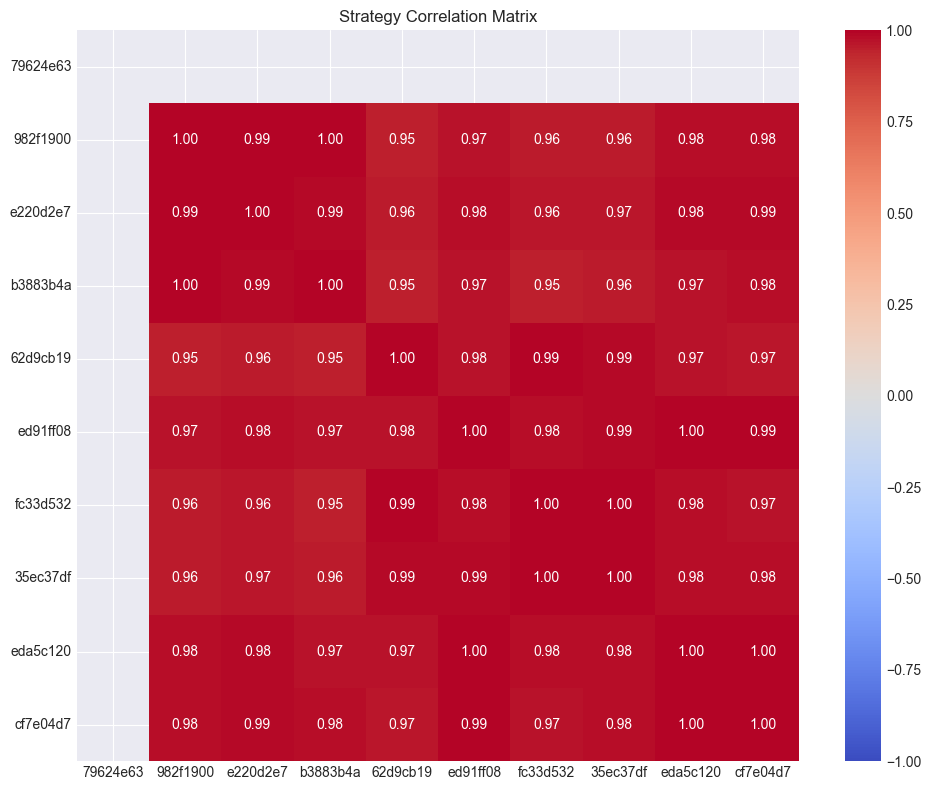


Correlation Statistics:
  Mean correlation: nan
  Median correlation: nan
  Min correlation: nan
  Max correlation: nan


In [15]:
# Optimized correlation calculation with progress tracking
if len(performance_df) > 0 and len(top_overall) > 1:
    print("\n🔗 Calculating correlations among top strategies...")
    print(f"Processing {len(top_overall)} strategies...")
    
    # First, load all returns data in one pass
    returns_dict = {}
    
    for idx, (_, row) in enumerate(top_overall.iterrows()):
        if idx % 5 == 0:
            print(f"  Loading signals: {idx}/{len(top_overall)}")
            
        try:
            signals_path = run_dir / row['trace_path']
            
            # Load signals
            signals = pd.read_parquet(signals_path)
            signals['ts'] = pd.to_datetime(signals['ts'])
            
            # Merge with market data (already in memory)
            df = market_data.merge(
                signals[['ts', 'val']], 
                left_on='timestamp', 
                right_on='ts', 
                how='left'
            )
            df['signal'] = df['val'].ffill().fillna(0)
            
            # Calculate strategy returns only once
            df['returns'] = df['close'].pct_change()
            df['strategy_returns'] = df['returns'] * df['signal'].shift(1)
            
            returns_dict[row['strategy_hash']] = df['strategy_returns'].values
        except Exception as e:
            print(f"  Warning: Could not load {row['strategy_hash'][:8]}: {e}")
    
    print(f"✅ Loaded returns for {len(returns_dict)} strategies")
    
    if len(returns_dict) >= 2:
        # Convert to DataFrame for correlation calculation
        returns_df = pd.DataFrame(returns_dict)
        
        # Calculate correlation matrix (this is fast once data is loaded)
        print("Calculating correlation matrix...")
        corr_matrix = returns_df.corr()
        
        # Find uncorrelated pairs
        uncorrelated_pairs = []
        n = len(corr_matrix)
        total_pairs = n * (n - 1) // 2
        
        pair_count = 0
        for i in range(n):
            for j in range(i+1, n):
                pair_count += 1
                    
                corr_val = corr_matrix.iloc[i, j]
                if abs(corr_val) < correlation_threshold:
                    uncorrelated_pairs.append({
                        'strategy1': corr_matrix.index[i],
                        'strategy2': corr_matrix.columns[j],
                        'correlation': corr_val
                    })
        
        print(f"✅ Found {len(uncorrelated_pairs)} uncorrelated pairs (correlation < {correlation_threshold})")
        
        # Visualize correlation matrix
        if len(corr_matrix) <= 20:
            plt.figure(figsize=(10, 8))
            # Only show annotations if matrix is small enough
            show_annot = len(corr_matrix) <= 10
            sns.heatmap(corr_matrix, cmap='coolwarm', center=0, vmin=-1, vmax=1, 
                       xticklabels=[h[:8] for h in corr_matrix.columns],
                       yticklabels=[h[:8] for h in corr_matrix.index],
                       annot=show_annot, fmt='.2f' if show_annot else None)
            plt.title('Strategy Correlation Matrix')
            plt.tight_layout()
            plt.show()
            
            # Show correlation statistics
            corr_values = corr_matrix.values[np.triu_indices_from(corr_matrix.values, k=1)]
            print(f"\nCorrelation Statistics:")
            print(f"  Mean correlation: {np.mean(corr_values):.3f}")
            print(f"  Median correlation: {np.median(corr_values):.3f}")
            print(f"  Min correlation: {np.min(corr_values):.3f}")
            print(f"  Max correlation: {np.max(corr_values):.3f}")
        else:
            print(f"Skipping heatmap visualization (too many strategies: {len(corr_matrix)})")
    else:
        print("❌ Not enough strategies loaded for correlation analysis")

## Ensemble Recommendations

In [16]:
# Build optimal ensemble
if len(performance_df) > 0 and 'corr_matrix' in locals() and not corr_matrix.empty:
    # Start with best strategy
    ensemble = [top_overall.iloc[0]['strategy_hash']]
    ensemble_data = [top_overall.iloc[0]]
    
    # Add uncorrelated strategies
    for idx, candidate in top_overall.iloc[1:].iterrows():
        if len(ensemble) >= ensemble_size:
            break
            
        # Check correlation with existing ensemble members
        candidate_hash = candidate['strategy_hash']
        if candidate_hash in corr_matrix.columns:
            max_corr = 0
            for existing in ensemble:
                if existing in corr_matrix.index:
                    corr = abs(corr_matrix.loc[existing, candidate_hash])
                    max_corr = max(max_corr, corr)
            
            if max_corr < correlation_threshold:
                ensemble.append(candidate_hash)
                ensemble_data.append(candidate)
    
    print(f"\n🎯 Recommended Ensemble ({len(ensemble)} strategies):")
    print("=" * 80)
    
    ensemble_df = pd.DataFrame(ensemble_data)
    for idx, row in ensemble_df.iterrows():
        print(f"\n{idx+1}. {row['strategy_type']} - {row['strategy_hash'][:8]}")
        print(f"   Sharpe: {row['sharpe_ratio']:.2f} | Return: {row['total_return']:.1%}")
    
    # Calculate ensemble metrics
    print(f"\nEnsemble Statistics:")
    print(f"  Average Sharpe: {ensemble_df['sharpe_ratio'].mean():.2f}")
    print(f"  Average Return: {ensemble_df['total_return'].mean():.1%}")
    print(f"  Strategy Types: {', '.join(ensemble_df['strategy_type'].unique())}")


🎯 Recommended Ensemble (2 strategies):

5. bollinger_bands - 79624e63
   Sharpe: 0.00 | Return: 0.0%

156. bollinger_bands - 982f1900
   Sharpe: -1.56 | Return: -18.5%

Ensemble Statistics:
  Average Sharpe: -0.78
  Average Return: -9.2%
  Strategy Types: bollinger_bands


<span id="papermill-error-cell" style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">Execution using papermill encountered an exception here and stopped:</span>

In [17]:
# Export recommendations with enhanced metrics
if len(performance_df) > 0:
    recommendations = {
        'run_info': {
            'run_id': run_dir.name,
            'config_name': config_name,
            'generated_at': datetime.now().isoformat(),
            'total_strategies': len(strategy_index) if strategy_index is not None else 0,
            'strategies_analyzed': len(performance_df),
            'execution_cost_bps': execution_cost_bps
        },
        'best_individual': {},
        'best_by_type': {},
        'ensemble': [],
        'stop_loss_recommendations': {
            'conservative': 0.25,
            'balanced': 0.50,
            'aggressive': 1.00
        }
    }
    
    # Best overall
    if len(top_overall) > 0:
        best = top_overall.iloc[0]
        recommendations['best_individual'] = {
            'strategy_hash': best['strategy_hash'],
            'strategy_type': best['strategy_type'],
            'sharpe_ratio': float(best['sharpe_ratio']),
            'total_return': float(best['total_return']),
            'max_drawdown': float(best['max_drawdown']),
            'win_rate': float(best.get('win_rate', 0)),
            'avg_return_per_trade': float(best.get('avg_return_per_trade', 0)),
            'num_trades': int(best.get('num_trades', 0)),
            'total_execution_cost': float(best.get('total_execution_cost', 0)),
            'parameters': {col.replace('param_', ''): best[col] 
                          for col in best.index if (col.startswith('param_') or col in ['period', 'std_dev', 'fast_period', 'slow_period', 'multiplier']) 
                          and pd.notna(best[col])}
        }
    
    # Best by type
    for stype in performance_df['strategy_type'].unique():
        type_best = performance_df[performance_df['strategy_type'] == stype].nlargest(1, 'sharpe_ratio')
        if len(type_best) > 0:
            row = type_best.iloc[0]
            recommendations['best_by_type'][stype] = {
                'strategy_hash': row['strategy_hash'],
                'sharpe_ratio': float(row['sharpe_ratio']),
                'total_return': float(row['total_return']),
                'win_rate': float(row.get('win_rate', 0)),
                'avg_return_per_trade': float(row.get('avg_return_per_trade', 0))
            }
    
    # Ensemble
    if 'ensemble_df' in locals():
        for idx, row in ensemble_df.iterrows():
            recommendations['ensemble'].append({
                'strategy_hash': row['strategy_hash'],
                'strategy_type': row['strategy_type'],
                'sharpe_ratio': float(row['sharpe_ratio']),
                'win_rate': float(row.get('win_rate', 0)),
                'weight': 1.0 / len(ensemble_df)  # Equal weight for now
            })
    
    # Add stop loss analysis results if available
    if 'stop_loss_results' in locals() and stop_loss_results:
        recommendations['stop_loss_analysis'] = {}
        for hash_id, sl_df in list(stop_loss_results.items())[:3]:  # Top 3 strategies
            optimal_idx = sl_df['total_return'].idxmax()
            recommendations['stop_loss_analysis'][hash_id[:8]] = {
                'optimal_stop_loss_pct': float(sl_df.loc[optimal_idx, 'stop_loss_pct']),
                'optimal_total_return': float(sl_df.loc[optimal_idx, 'total_return']),
                'improvement_pct': float((sl_df.loc[optimal_idx, 'total_return'] - sl_df.loc[0, 'total_return']) * 100)
            }
    
    # Save files
    with open(run_dir / 'recommendations.json', 'w') as f:
        json.dump(recommendations, f, indent=2)
    
    performance_df.to_csv(run_dir / 'performance_analysis.csv', index=False)
    
    # Also save enhanced metrics
    enhanced_metrics_df = performance_df[['strategy_hash', 'strategy_type', 'sharpe_ratio', 'total_return', 
                                         'win_rate', 'avg_return_per_trade', 'num_trades', 'total_execution_cost']].copy()
    enhanced_metrics_df.to_csv(run_dir / 'enhanced_metrics.csv', index=False)
    
    print("\n✅ Results exported:")
    print(f"  - recommendations.json (with enhanced metrics)")
    print(f"  - performance_analysis.csv")
    print(f"  - enhanced_metrics.csv")
else:
    print("⚠️ No results to export")

TypeError: Object of type int64 is not JSON serializable

## Summary

Analysis complete! Key files generated:
- `recommendations.json` - Best strategies and ensemble recommendations
- `performance_analysis.csv` - Full performance data for all strategies

Next steps:
1. Use the recommended ensemble for live trading
2. Deep dive into specific strategy types if needed
3. Run regime-specific analysis to understand performance drivers